In [1]:
# Standard imported packages
import numpy as np  
import symengine as sp

# Tools from Bocop's Python API
from BocopUtils import readSolFile

# Tools from our
from symengine_function import gradient, lie_bracket, xp_bracket
from shooting import shooting
#from sympy.parsing.sympy_parser import parse_expr

In [2]:
# Plotting parameters

from matplotlib import pyplot as plt

plt.style.use('seaborn')
from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

marker_style = dict(color = 'tab:red', linestyle = '--', marker = 'o',
                    markersize = 7, markerfacecoloralt = 'tab:green')

params = {'legend.fontsize': 13,
          'legend.handlelength': 2}
plt.rcParams.update(params)

# First example: Simple unconstrained problem

Our first example is an unconstrained optimal control problem in Bolza form

\begin{equation*}
			\begin{array}{rl}
			\text{ minimize} & \frac{1}{2}\int_{0}^{12}\left((x(t)-10)^2 + u(t)^2\right){\rm d} t\\
			\text{subject to}& \dot{x}(t) = u(t) - 5\sin (t), \ 0\le t\le 12,\\
			& x(0) = 5.
		\end{array}
\end{equation*}

We can rewrite it in Mayer with autonomous dynamics form defining the new states $x_1 = t$ and $x_2$ beging the running cost satisfying
\begin{equation*}
    \dot{x}_1 = 1, \quad \dot{x}_2 = \frac{1}{2}\left((x(t)-10)^2 + u(t)^2\right)
\end{equation*}

For this problem, the shooting function is easy to formulate. 
\begin{equation*}
		\mathcal{S}(p(0), p_1(0)) = 
		\left(
		\begin{array}{c}
			p(12)\\
			p_1(12)
		\end{array}
		\right)
\end{equation*}

In this problem the control $u$ appears nonlinearly. 

In [3]:
states_list         = 'x1 x2'                     # Declares the list of states, x2 = t
nonlin_cont_list    = 'u'
running_cost_list   = '0.5*((x1-10.0)**2 + u**2)' # In our implementation it is possible to define the running cost
                                                  # it is not necessary to write in Mayer form, this was automated 

# Define dynamics strings
drift_dynamics_list = ['u -5.0*sin(x2)', '1']

# Constructor for the shooting algorithm class
shooting_algorithm = shooting(states_list, 
                              arcs_list        = None, 
                              lin_cont_list    = None, 
                              nonlin_cont_list = nonlin_cont_list, 
                              running_cost     = running_cost_list, 
                              time_horizon     = [0.0, 12.0])

# Add drift and affine dynamics
shooting_algorithm.add_drift_dynamics(drift_dynamics_list)
shooting_algorithm.add_constrainst_IF(cost_function_str   = None,
                                      constraints_IF_list = None)

# Nonlinear controls obtained from the stationarity conditions
control_subs_dict = {'u' : '-p_x1'}
shooting_algorithm.f0 = shooting_algorithm.f0.subs(control_subs_dict)


# Function sym_to_numpy computes the symbolic: Shooting Function and derivatives, 
#                                      TP dynamics and variational dynamics.
#
# And later converts them to called functions that return numpy arrays and matrices

shooting_algorithm.sym_to_numpy()

# Shooting arguments are randomly set to 1
shooting_args      = np.array([1.0, 1.0]).reshape(2,1)
states_ini_cond = np.array([5.0, 0.0, 0.0]).reshape(3,1)
    
initial_conditions, shot = shooting_algorithm.solve_shooting(shooting_args, states_ini_cond, tol = 1e-10)

print('Optimal initial conditions: \n', initial_conditions)
print('Shooting function evaluated at optimal initial conditions: \n', shot)


No initial-final constraints added to the Shooting Function


/home/jmmmachado/Dropbox/LatexFilesResearch/Joao&Soledad/Mixed Controls/shooting/Shooting_BOCOP comparison/github examples/shooting.py:1036: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if initial_conditions != 'free':


iteration:   1, |S|:   872236.6751322025, integration steps:   606;
rank A:   2 rank D_shot:   2 


iteration:   2, |S|:   67238.94298352476, integration steps:   537;
rank A:   2 rank D_shot:   2 


iteration:   3, |S|:   3624.5297121884405, integration steps:   462;
rank A:   2 rank D_shot:   2 


iteration:   4, |S|:   178.84750350226693, integration steps:   389;
rank A:   2 rank D_shot:   2 


iteration:   5, |S|:   9.192328325169623, integration steps:   334;
rank A:   2 rank D_shot:   2 


iteration:   6, |S|:   0.8673669307370157, integration steps:   331;
rank A:   2 rank D_shot:   2 


iteration:   7, |S|:   0.05190653670172055, integration steps:   332;
rank A:   2 rank D_shot:   2 


iteration:   8, |S|:   0.004978933957620061, integration steps:   332;
rank A:   2 rank D_shot:   2 


iteration:   9, |S|:   0.0003726742148937064, integration steps:   332;
rank A:   2 rank D_shot:   2 


iteration:   10, |S|:   2.804210985551079e-05, integration steps:   332;
rank A:   2 ran

/home/jmmmachado/Dropbox/LatexFilesResearch/Joao&Soledad/Mixed Controls/shooting/Shooting_BOCOP comparison/github examples/shooting.py:1098: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if initial_conditions != 'free':


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


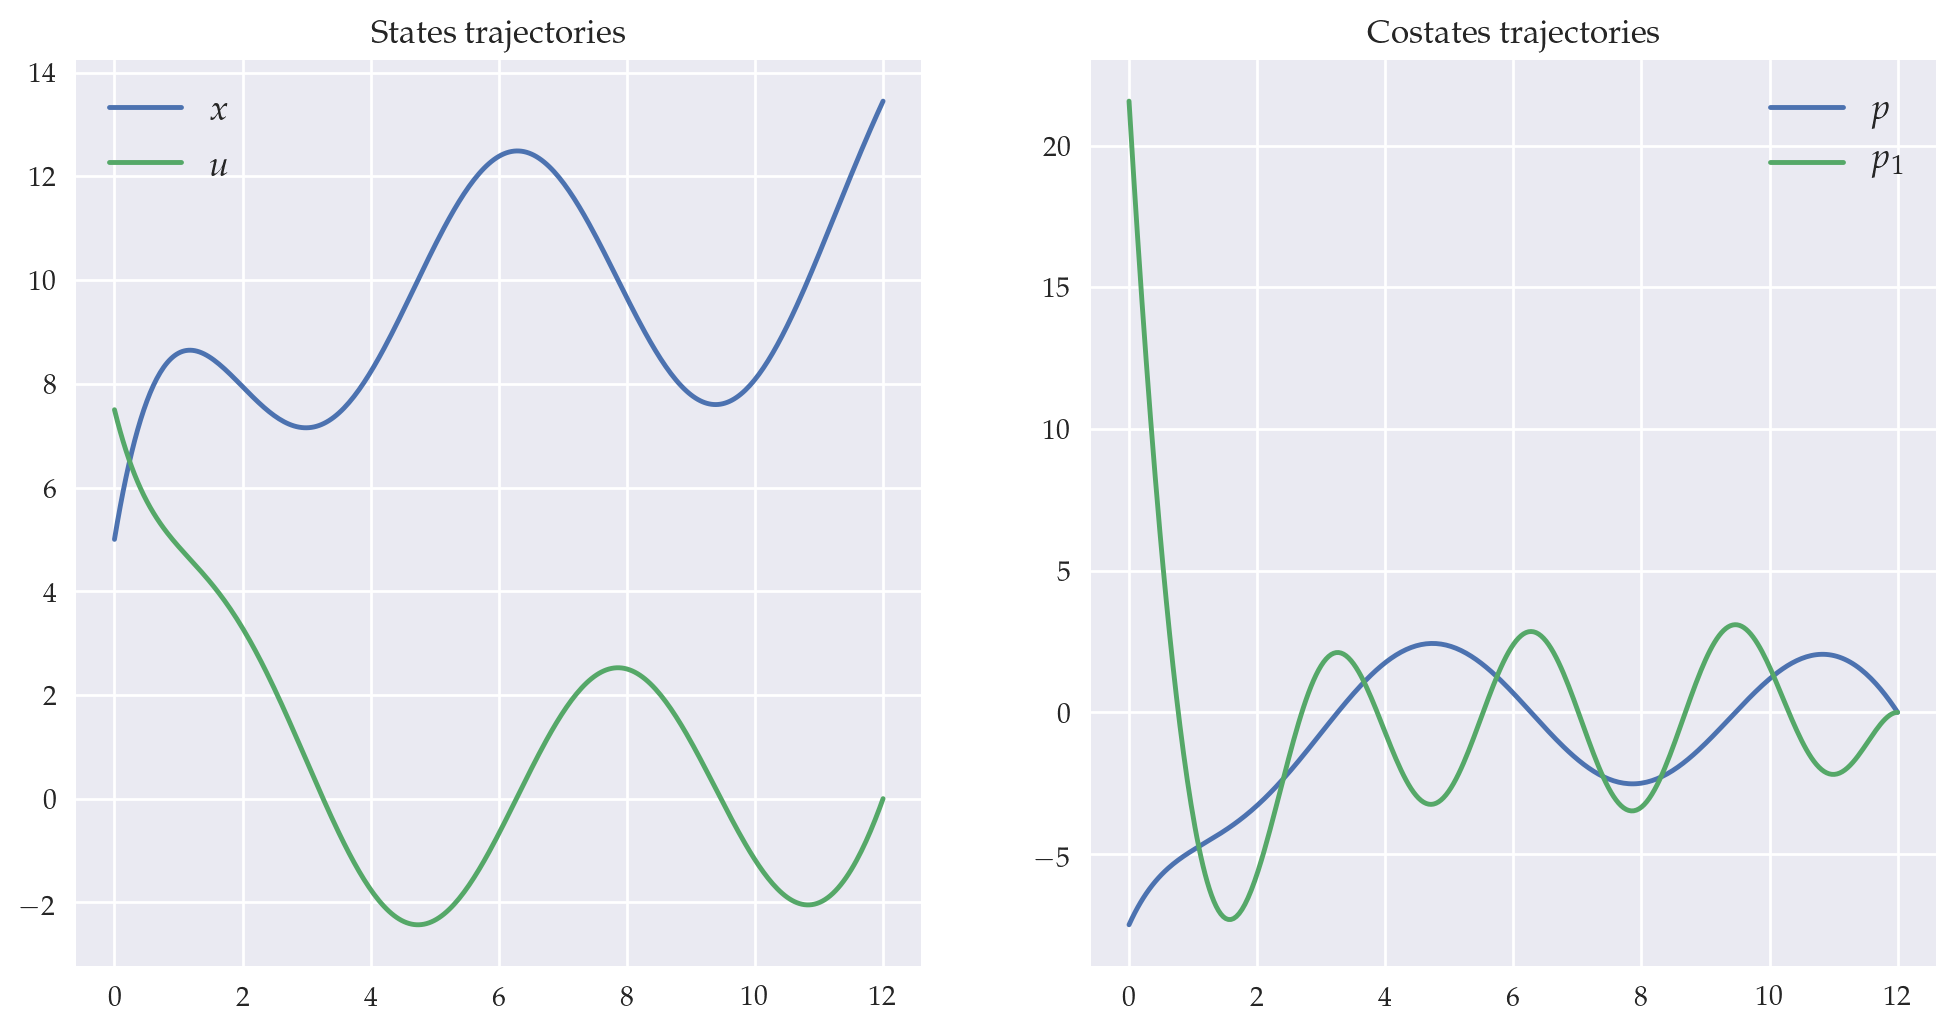

In [4]:
# After we obtained the optimal initial conditions, this function gives the optimal trajectory
states, costates, times = shooting_algorithm.optimal_trajectory(initial_conditions, control_bounds = None)


plt.figure(figsize=(12,6), dpi= 200, facecolor='w', edgecolor='k')
plt.subplot(121)
plt.title('States trajectories')
plt.plot(times, states[:,0], label = '$x$')
plt.plot(times, -costates[:,0], label = '$u$')
plt.legend()

plt.subplot(122)
plt.title('Costates trajectories')
plt.plot(times, costates[:,0], label = '$p$')
plt.plot(times, costates[:,1], label = '$p_1$')
plt.legend()
plt.show()


# Second Example: 2-compartiment cancer model

Our second example studies the optimal treatment of a mathematical model for the dynamics of cancerous cells population divided in two compartiments $N_1$ and $N_2$. The population $N_2$ is inactive in the stage of mitosis, each giving birth to two active cells $N_1$. Hence the drug $u$ only effects the active population $N_1$. 

\begin{equation}
	\begin{array}{rl}
		\text{ minimize} & r\cdot N(T) + \frac{1}{2}\int_{0}^{T}\left(q\cdot N(t) + su(t)\right) {\rm d} t\\
		\text{subject to}& 
		\left(
		\begin{array}{c}
		\dot{N}_1(t)\\
		\dot{N}_2(t)
		\end{array}
		\right) =
		\left(
		\begin{array}{cc}
		-a_1 & 2a_2\\
		a_1 & -a_2
		\end{array}
		\right)
		\left(
		\begin{array}{c}
		N_1(t)\\
		N_2(t)
		\end{array}
		\right) + u(t)
		\left(
		\begin{array}{c}
		-2a_2N_2(t)\\
		0
		\end{array}
		\right),\\
		& N_1(0) = N_1^*,\quad N_2(0) = N_2^*, \\
		& u(t) \in [0, u_{\max}].
	\end{array}
\end{equation}

For this problem the optimal controls will be bang bang. We use BOCOP to find the structure of the optimal solution. The following cell obtains such structure analysing the output for a solution file, prob.sol, given as a output from the BOCOP software. 

String for optimal arcs structure:  ['bang_plus', 'bang_minus']
Estimate for switching times:  [15.0]


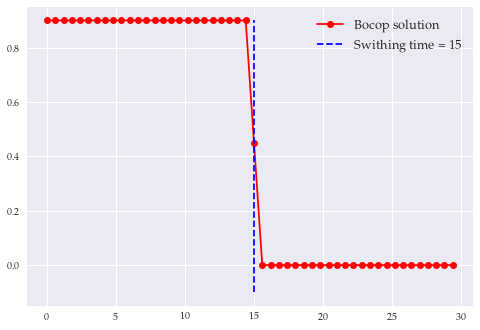

In [5]:
objective, time_steps, time_stages, state, control, parameters, costate, boundary_mult, status = readSolFile('Bocop Sol Files/cancer1_prob.sol')
# since the method used was Gauss-2, 2 stage method, 
# the controls double resolution than the states and costates
control = (control[:,::2] + control[:,1::2])/2

SF_Bocop    = []
SF_Bocop_dt = []

xp_all_BOCOP = np.append(state[:,0:-1], costate[0:2,:], axis = 0)

Switching_Times         = []
Switching_Times_indexes = []
arcs                    = []

final_time = 30.0
times = final_time*time_steps[0:-1]


################################################################
# This script obtains an estimate for the optimal arcs structure
################################################################
control_bounds = [0.0, 0.9] # u_max = 0.9
if control[0,0] == control_bounds[0]:
    arcs.append('bang_minus')
if control[0,0] == control_bounds[1]:
    arcs.append('bang_plus')
if control[0,0] != control_bounds[0] and control[0,0] != control_bounds[1]:
    arcs.append('sing')

for k in range( times.shape[0]):
    # First we check current arc
    if control[0,k] == control_bounds[0]:
        arc = 'bang_minus'
    elif control[0,k] == control_bounds[1]:
        arc = 'bang_plus'
    elif control[0,k+1] != control_bounds[0] and control[0,k+1] != control_bounds[1]:
        arc = 'sing'
    
    # If the arc type has changed, we append a new arc
    if arc != arcs[-1]:
        arcs.append(arc)
        Switching_Times.append(times[k-1])
        Switching_Times_indexes.append(k-1)
    pass
pass 
print('String for optimal arcs structure: ', arcs)
print('Estimate for switching times: ', Switching_Times)

plt.figure()
plt.plot(times, control[0,:], 'ro-', label = 'Bocop solution' )
plt.plot(Switching_Times[0]*np.ones(100),np.linspace(-0.1, 0.9, 100), 'b--', label = 'Swithing time = 15')
plt.legend()
plt.show()

Afterwards we use the indexes of the switching times to obtain estimates for the shooting arguments.

In [6]:
length = state[:, Switching_Times_indexes].shape[0]*state[:, Switching_Times_indexes].shape[1]
states_estimates = state[:, Switching_Times_indexes].T.reshape(length,)

length_costates  = costate[0:2, Switching_Times_indexes].shape[0]*costate[0:2, Switching_Times_indexes].shape[1]
costates_initial = costate[0:2,0].reshape(2,)
costates_estimates = costate[0:2, Switching_Times_indexes].T.reshape(length_costates,)


print(states_estimates)
shooting_args = np.append(states_estimates, costates_initial, axis = 0)
shooting_args = np.append(shooting_args, costates_estimates, axis = 0)
shooting_args = np.append(shooting_args, Switching_Times, axis = 0)
shooting_args = shooting_args.reshape(shooting_args.shape[0],1)
#shooting_args = states_estimates.append(costates_initial).append(costates_estimates).append(Switching_Times)
print(shooting_args)


[0.05453682 0.04917585 7.30244119]
[[ 0.05453682]
 [ 0.04917585]
 [ 7.30244119]
 [ 4.76482546]
 [ 1.72837889]
 [14.90593359]
 [22.87186864]
 [15.        ]]


In [7]:
#########################################################
# Set up Shooting Algorithm
#########################################################

states_list         = 'n1 n2'
lin_cont_list       = 'v'
arcs_list           = arcs 
cost_function_list  = '3.0*(n1_f + n2_f)'
running_cost_list   = '0.1*n1 + 0.1*n2 + 0.5*v'

# Define dynamics strings
drift_dynamics_list  = ['-0.197*n1 + 2*(0.356)*n2', '0.197*n1 - 0.356*n2']
affine_dynamics_list = ['-2*(0.356)*n2', '0.0']

# Constructor for the shooting algorithm class
shooting_algorithm = shooting(states_list, 
                              arcs_list, 
                              lin_cont_list, 
                              nonlin_cont_list = None, 
                              running_cost = running_cost_list, 
                              time_horizon = [0.0,final_time])

# Add drift and affine dynamics
shooting_algorithm.add_drift_dynamics(drift_dynamics_list)
shooting_algorithm.add_lin_dynamics(affine_dynamics_list, bounds= [0.0, 0.9])

# Compute Singular Linear Control
shooting_algorithm.sing_cont_lin_only()

# Assemble initial-final lagrangian
shooting_algorithm.add_constrainst_IF(cost_function_list)

# Generate numpy functions from sympy/symengine symbolic expressions
shooting_algorithm.sym_to_numpy()

# Estimates for initial conditions
#shooting_args = np.array([0.0008, 0.0007,  21.5,  4.65, 1.654, 992.0, 1528.0, 46.4]).reshape(8,1)
initial_conditions = np.array([0.2988, 0.7012, 0.0]).reshape(3,1)

initial_conditions, shot_final = shooting_algorithm.solve_shooting(shooting_args, 
                                                                   initial_conditions, 
                                                                   tol = 1e-10 )

print(initial_conditions, '\n\n', shot_final)

No initial-final constraints added to the Shooting Function


/home/jmmmachado/Dropbox/LatexFilesResearch/Joao&Soledad/Mixed Controls/shooting/Shooting_BOCOP comparison/github examples/shooting.py:1036: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if initial_conditions != 'free':


iteration:   1, |S|:   3.1414246039153437, integration steps:   124;
rank A:   8 rank D_shot:   8 


iteration:   2, |S|:   0.8038257608015624, integration steps:   123;
rank A:   8 rank D_shot:   8 


iteration:   3, |S|:   0.025299899470366247, integration steps:   123;
rank A:   8 rank D_shot:   8 


iteration:   4, |S|:   0.0003887850832788936, integration steps:   123;
rank A:   8 rank D_shot:   8 


iteration:   5, |S|:   5.663598478290225e-06, integration steps:   123;
rank A:   8 rank D_shot:   8 


iteration:   6, |S|:   8.511010247180647e-08, integration steps:   123;
rank A:   8 rank D_shot:   8 


iteration:   7, |S|:   1.3651082953210123e-09, integration steps:   123;
rank A:   8 rank D_shot:   8 


iteration:   8, |S|:   9.021318243856226e-11, integration steps:   123;
rank A:   8 rank D_shot:   8 


[[ 0.2988    ]
 [ 0.7012    ]
 [ 0.        ]
 [ 0.05142981]
 [ 0.04628339]
 [ 7.50555818]
 [ 4.35751807]
 [ 1.58699179]
 [15.17277063]
 [23.28278636]
 [15.44149324]] 

 [[ 1.

/home/jmmmachado/Dropbox/LatexFilesResearch/Joao&Soledad/Mixed Controls/shooting/Shooting_BOCOP comparison/github examples/shooting.py:1098: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if initial_conditions != 'free':


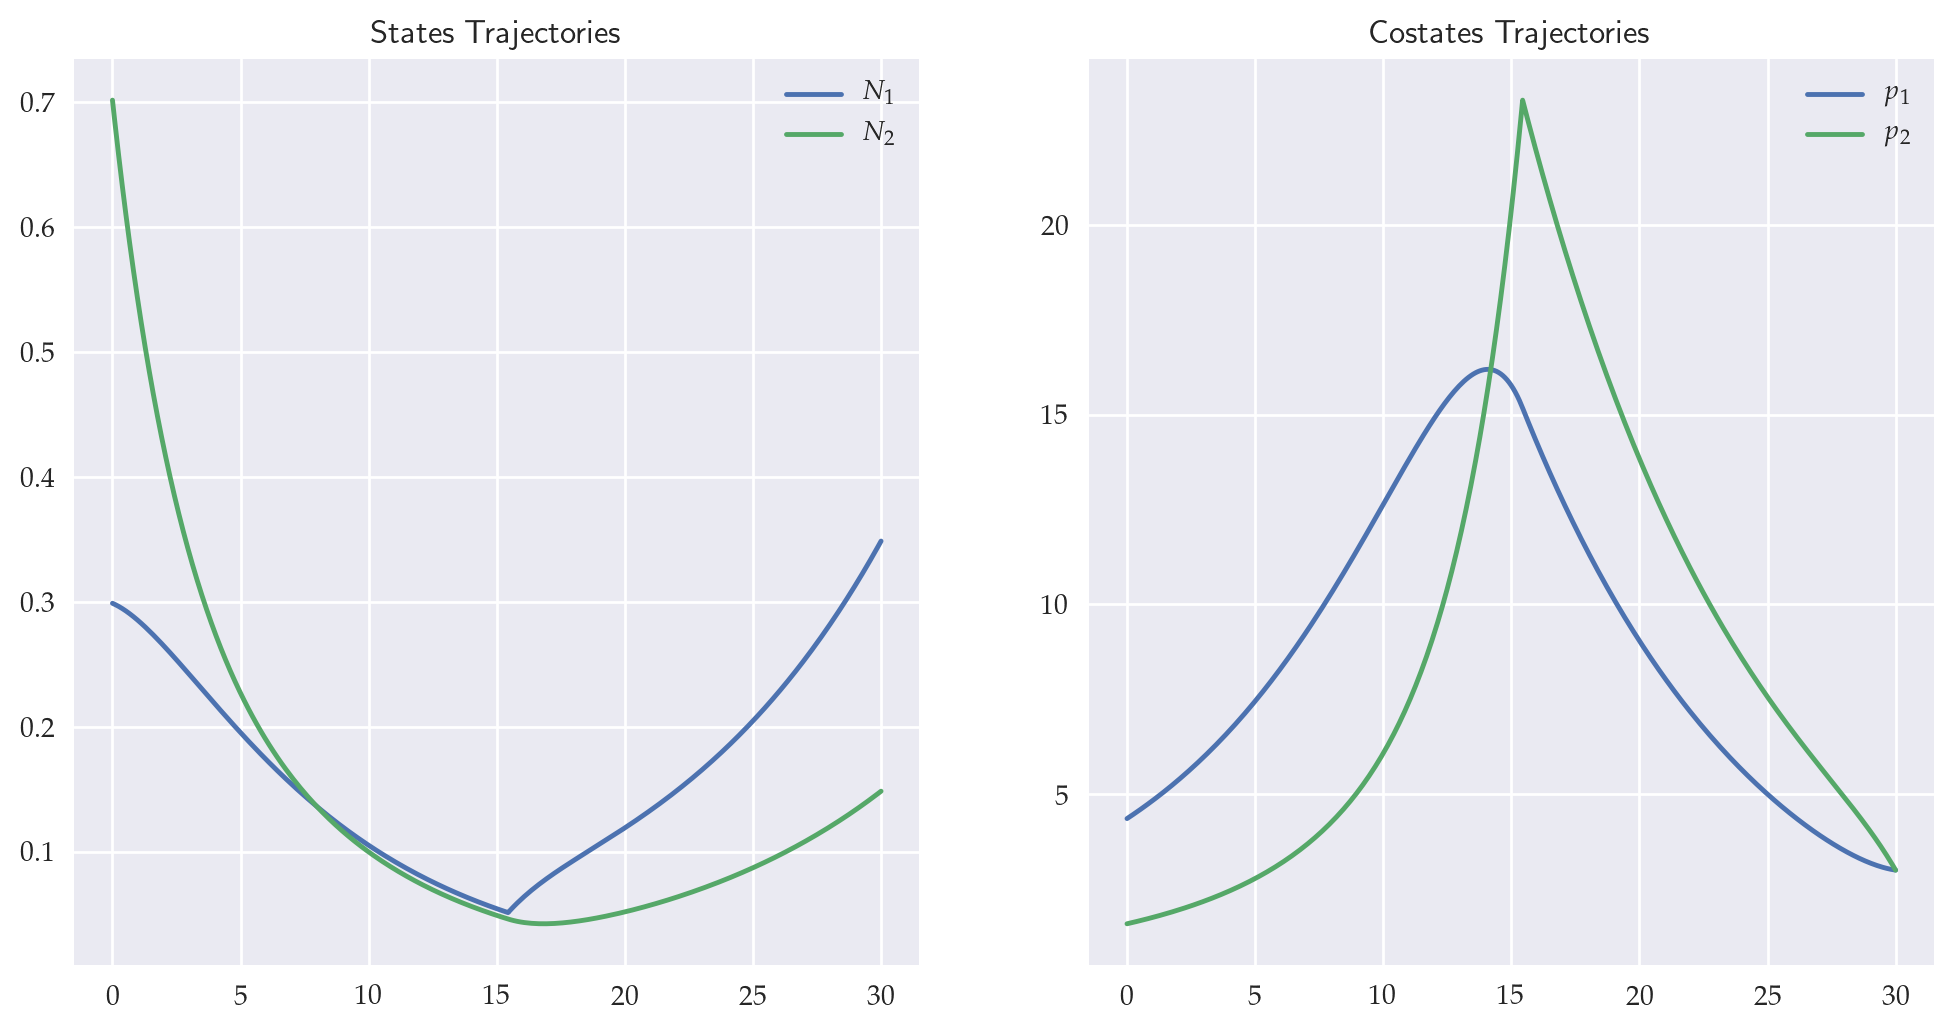

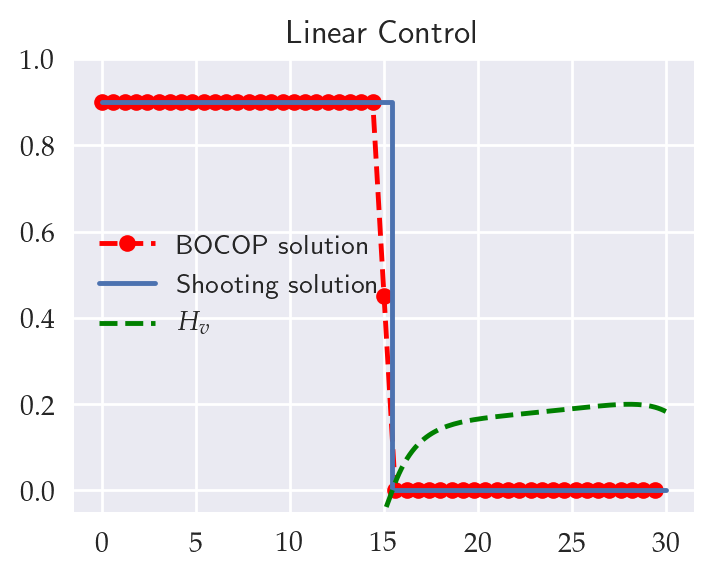

In [8]:
############################################
# Plotting optimal trajectories
############################################

times, controls, states, costates, switching_function, switching_function_dt = shooting_algorithm.optimal_trajectory(initial_conditions, control_bounds = [0.0, 0.9])
x_1 = states[:,0]
x_2 = states[:,1]
x_3 = states[:,2]

plt.style.use('seaborn')
from matplotlib import rc
rc('text', usetex=True)




plt.figure(figsize=(12,6), dpi= 200, facecolor='w', edgecolor='k')
plt.subplot(121)
plt.title('States Trajectories')
plt.plot(times, states[:,0], label = '$N_1$')
plt.plot(times, states[:,1], label = '$N_2$')
#plt.plot(times, states[:,2], label = 'running cost')
plt.legend()

plt.subplot(122)
plt.title('Costates Trajectories')
plt.plot(times, costates[:,0], label = '$p_1$')
plt.plot(times, costates[:,1], label = '$p_2$')
plt.legend()
plt.show()

plt.figure(figsize=(4,3), dpi= 200, facecolor='w', edgecolor='k')
plt.title('Linear Control')
plt.plot(final_time*time_steps[0:-1] ,control[0,:], 'ro--', markersize = 6, label = 'BOCOP solution')
plt.plot(times , controls ,label = 'Shooting solution')
plt.plot(times, switching_function, 'g--',label = '$H_v$')
#plt.plot(times, switching_function_dt/200.0, '--y',label = '$H_v$')
plt.ylim((-0.05, 1.0))
plt.legend()

plt.show()

# Tird Example: SIRS model with vaccination and treatment

\begin{equation}
\begin{array}{cl}
\text{minimize} & \int_0^T B_1I + B_2v + B_3u^2 {\rm d}t \\
\text{subject to} & \dot{N} = F(N) - \delta I - \mu N,\\
&\dot{S} = F(N) - \beta \frac{IS}{N} -vS + \omega (N - S - I) - \mu S, \\
&\dot{I} = \beta \frac{IS}{N} - (\gamma + \delta + u)I - \mu I,\\
& 0\le v(t) \le v_{\max}, \quad \text{a.e. on $[0,T]$}\\
& 0\le u(t) , \quad \text{a.e. on $[0,T]$}\\
& N(0) = N_0, \quad S(0) = S_0, \quad I(0) = I_0, \quad C(0) = 0.
\end{array}
\end{equation}

In [12]:
states_list         = 'n s i'
lin_cont_list       = 'v'
nonlin_cont_list    = 't'
arcs_list           = ['bang_plus', 'sing', 'bang_minus']
cost_function_list  = '0.0'
running_cost_list   = 'i + 50.0*v + 1000.0*t**2'


affine_dynamics_list  = ['0.0', '-s', '0.0']

drift_dynamics_list   = ['4e-5*n*(1.0 - n/5000.0) - 0.01*i - 0.5e-5*n', 
                         '4e-5*n*(1.0 - n/5000.0) - 0.5*i*s/n + 0.01*(n-s-i) - 0.5e-5*s', 
                         '0.5*i*s/n - (0.1 + 0.1 + t)*i - 0.5e-5*i']


shooting_algorithm = shooting(states_list, arcs_list, lin_cont_list, nonlin_cont_list = nonlin_cont_list,
                              running_cost = running_cost_list, time_horizon = [0.0, 100.0])

# Add drift and affine dynamics
shooting_algorithm.add_drift_dynamics(drift_dynamics_list)
shooting_algorithm.add_lin_dynamics(affine_dynamics_list, bounds = [0.0, 0.25])

# Add final constraints
shooting_algorithm.add_constrainst_IF(cost_function_str   = cost_function_list, 
                                      constraints_IF_list = None)

control_subs_dict = {'t' : 'i*p_i/(2000.0)'}
shooting_algorithm.singular_control_symbolic(control_subs_dict)

shooting_algorithm.sym_to_numpy()
# Estimates for parameters: 
#B1 = 1, B2 = 50, B3 = 1000, K = 5000, delta = 0.1, beta = 0.5, 
# gamma = 0.1, omega = 0.01, alpha = 4e-5, mu = 4e-5, T_f = 100.0
# BOCOP steps = 200
shooting_args = y = np.array([4865.2, 420.0, 25.9, 2440.0,
                              4851.2, 1290.0, 0.5, 2638.0,
                              -0.178, 0.238, 3.12,
                              -0.0101, 0.118, 6.1,
                              -0.0101, 0.038, 44., 
                              9., 44.2]).reshape(19,1)

#shooting_args += 0.1*np.random.randn(19,1)


initial_conditions = np.array([5000.0, 4500.0, 499.0, 0.0]).reshape(4,1)


initial_conditions, shot_final = shooting_algorithm.solve_shooting(shooting_args, 
                                                                   initial_conditions, 
                                                                   tol = 1e-10)

print(initial_conditions, '\n\n', shot_final)

times, controls, states, costates, switching_function, switching_function_dt = shooting_algorithm.optimal_trajectory(initial_conditions, control_bounds = [0.0, 0.25])


No initial-final constraints added to the Shooting Function
iteration:   1, |S|:   1465.0391640955427, integration steps:   262;
rank A:   18 rank D_shot:   19 


iteration:   2, |S|:   610.2563137114076, integration steps:   196;
rank A:   18 rank D_shot:   19 


iteration:   3, |S|:   263.0171278264318, integration steps:   210;
rank A:   18 rank D_shot:   19 


iteration:   4, |S|:   124.24175794820628, integration steps:   227;
rank A:   19 rank D_shot:   19 


iteration:   5, |S|:   36.77577469192976, integration steps:   249;
rank A:   19 rank D_shot:   19 


iteration:   6, |S|:   745.4545366267088, integration steps:   184;
rank A:   18 rank D_shot:   19 


iteration:   7, |S|:   1018.9036952068324, integration steps:   199;
rank A:   18 rank D_shot:   19 


iteration:   8, |S|:   756.3570199890257, integration steps:   232;
rank A:   18 rank D_shot:   19 


iteration:   9, |S|:   196.93807904694197, integration steps:   222;
rank A:   18 rank D_shot:   19 


iteration:   10, |

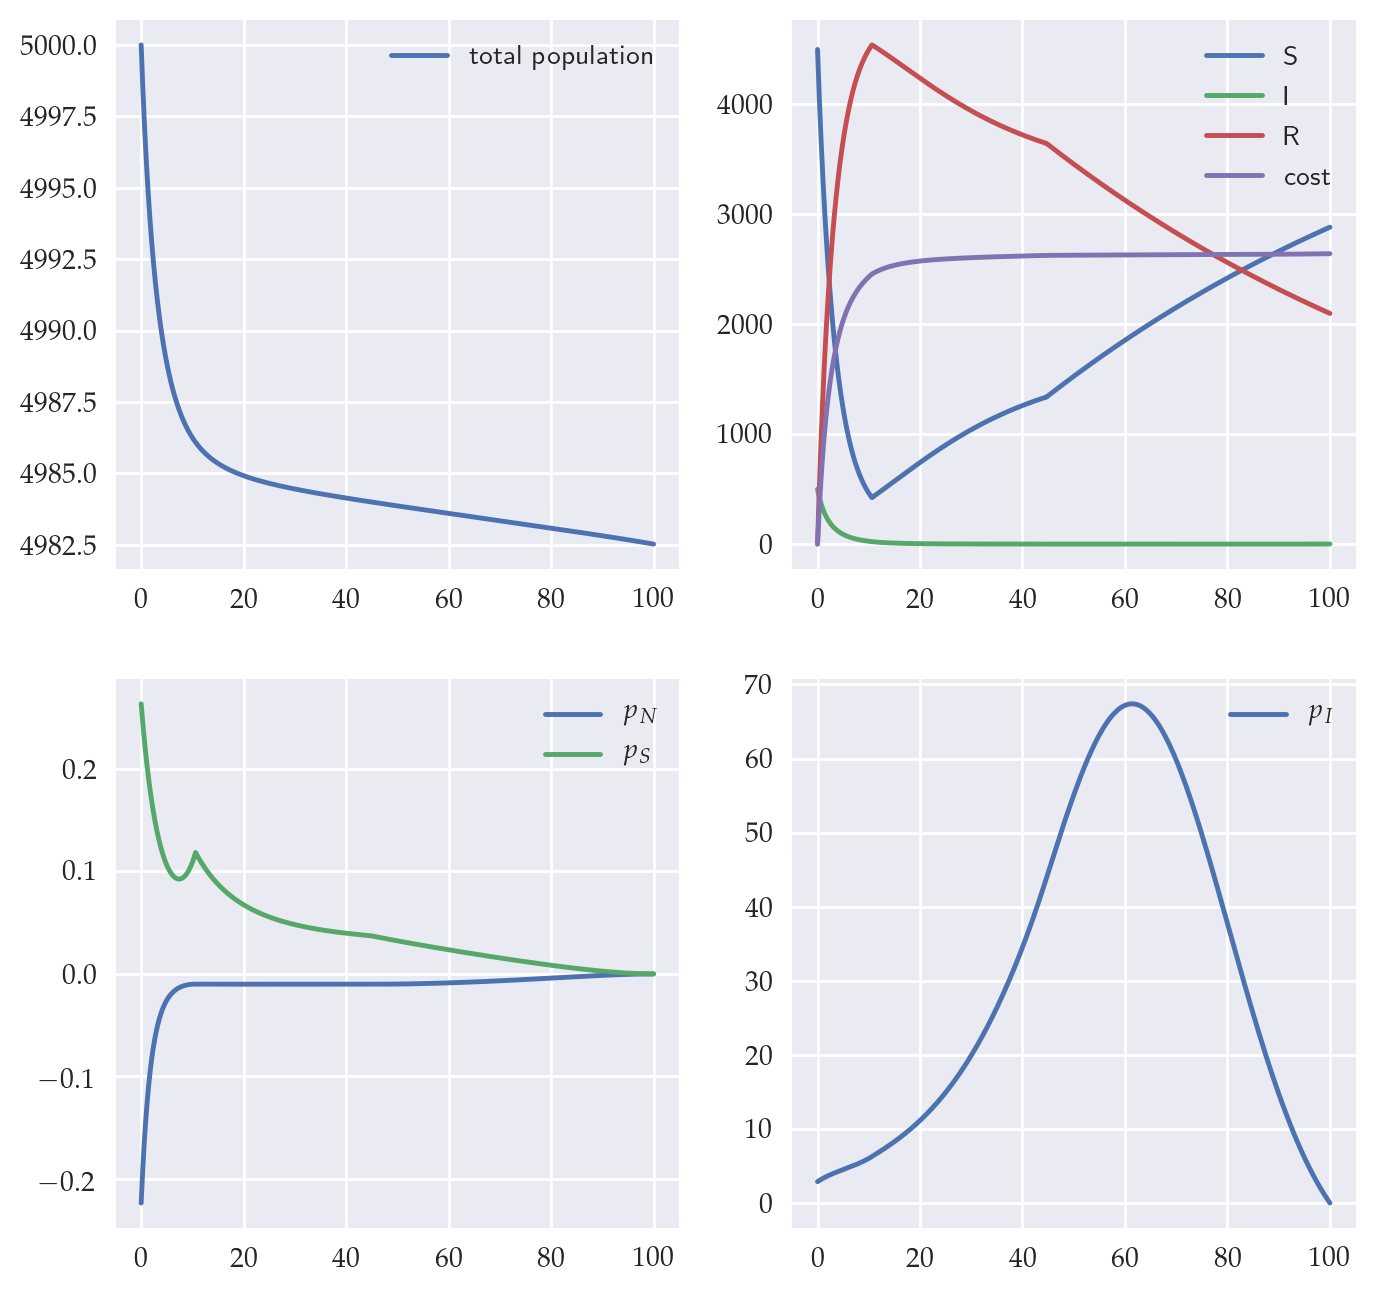

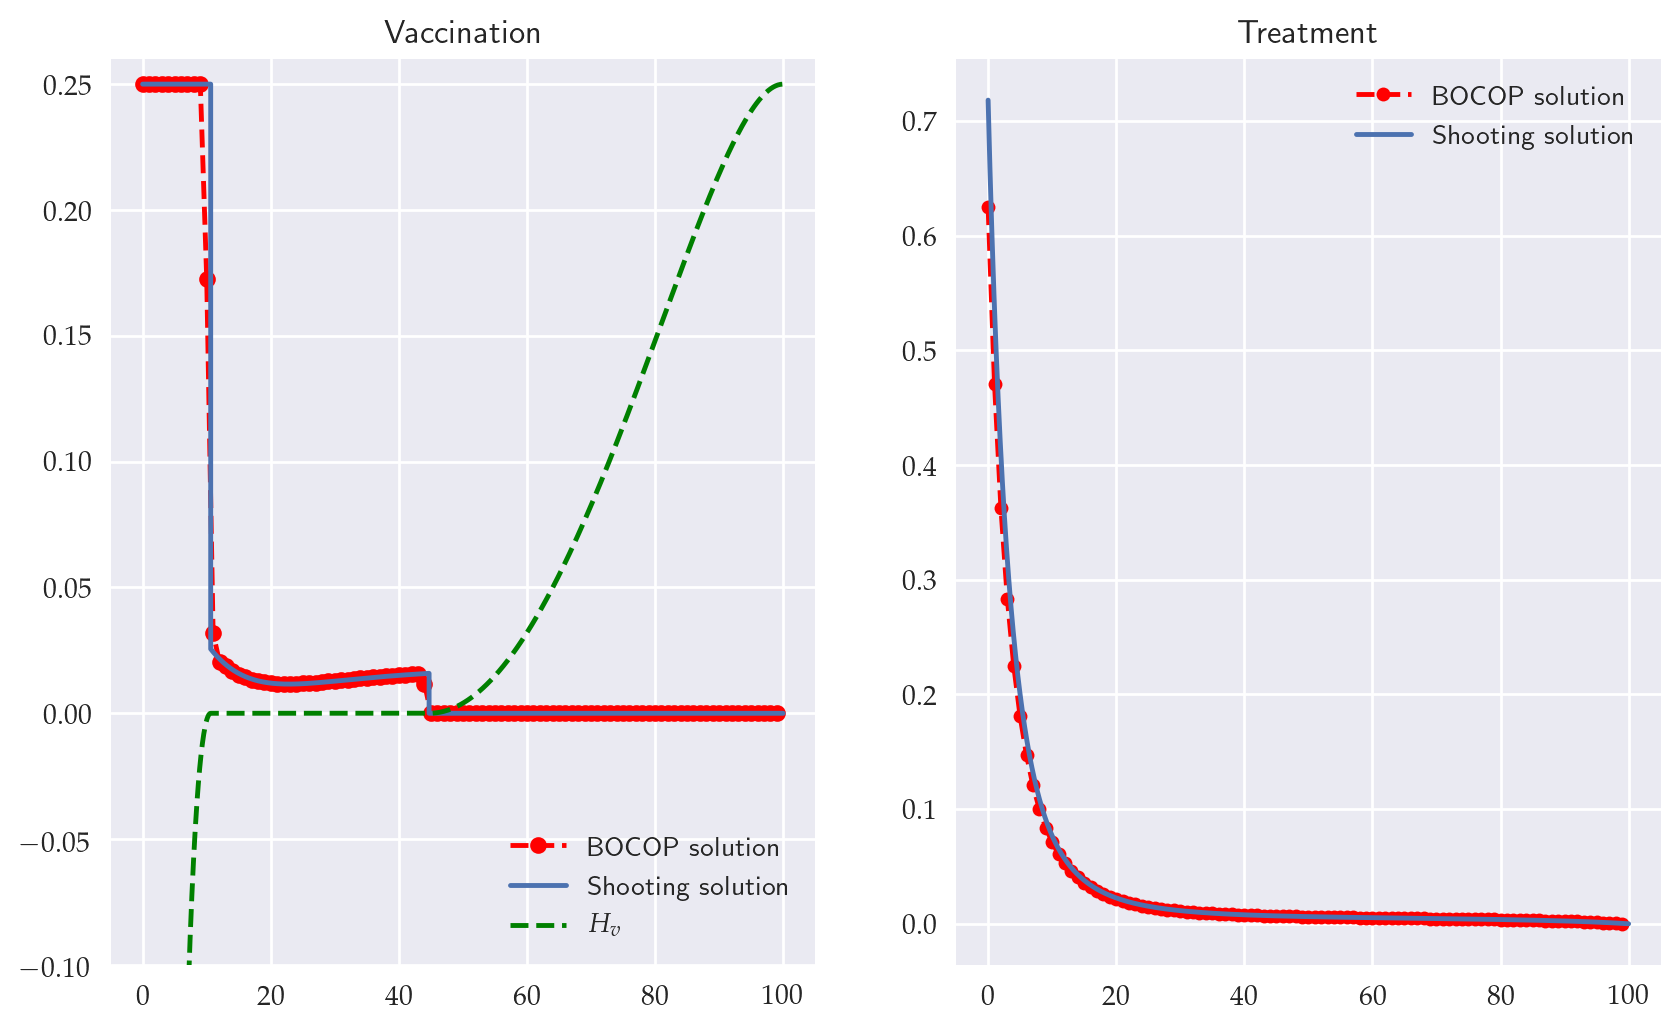

In [13]:
#######################
# Read BOCOP solution
#######################

objective, time_steps, time_stages, state, control, parameters, costate, boundary_mult, status = readSolFile('Bocop Sol Files/SIRS_T100_prob.sol')
# since the method used was Gauss-2, 2 stage method, 
# the controls double resolution than the states and costates
control = (control[:,::2] + control[:,1::2])/2

SF_Bocop    = []
SF_Bocop_dt = []

xp_all_BOCOP = np.append(state[:,0:-1], costate[0:3,:], axis = 0)
SF_Bocop = shooting_algorithm.switching_function_np(xp_all_BOCOP.T)
SF_Bocop_dt = shooting_algorithm.switching_function_dt_np(xp_all_BOCOP.T)

############################################
# Plotting optimal trajectories
############################################

N = states[:,0]
S = states[:,1]
I = states[:,2]
R = N - S - I 

S_normalized = S/N
I_normalized = I/N
R_normalized = R/N


plt.figure(figsize=(8,8), dpi= 200, facecolor='w', edgecolor='k')
plt.subplot(221)
plt.plot(times, N, label = 'total population')
#plt.plot(times, 100*S_normalized, label = 'percentage of susceptible')
#plt.plot(times, 100*I_normalized, label = 'percentage of infected')
#plt.plot(times, 100*R_normalized, label = 'percentage of recovered')
plt.legend()
plt.subplot(222)
plt.plot(times, S, label = 'S')
plt.plot(times, I, label = 'I')
plt.plot(times, R, label = 'R')
plt.plot(times, states[:,3], label = 'cost')
plt.legend()

plt.subplot(223)
plt.plot(times, costates[:,0], label = '$p_N$')
plt.plot(times, costates[:,1], label = '$p_S$')
plt.legend()

plt.subplot(224)
plt.plot(times, costates[:,2], label = '$p_I$')
plt.legend()
plt.show()

final_time = 100.0

plt.figure(figsize=(10,6), dpi= 200, facecolor='w', edgecolor='k')
plt.subplot(121)
plt.title('Vaccination')
plt.plot(final_time*time_steps[0:-1] ,control[0,:], 'ro--', markersize = 6, label = 'BOCOP solution')
plt.plot(times , controls ,label = 'Shooting solution')
plt.plot(times, switching_function/200.0, 'g--',label = '$H_v$')
#plt.plot(times, switching_function_dt/200.0, '--y',label = '$H_v$')
plt.ylim((-0.1, 0.26))
plt.legend()

plt.subplot(122)
plt.title('Treatment')
plt.plot(final_time*time_steps[0:-1] ,control[1,:], 'ro--', markersize = 5, label = 'BOCOP solution')
plt.plot(times , I*costates[:,2]/2000.0 ,label = 'Shooting solution')
plt.legend()
plt.show()